In [10]:
#!pip install openpyxl
#!git clone https://github.com/unpackAI/DL201.git


import pandas as pd
import numpy as np
import cv2 
import torch as t
from matplotlib import pyplot as plt

# Imports 
from pathlib import Path

#Kaggle config
#DATA_DIR = Path('/kaggle/working/DL201/data') #uncomment for kaggle
#IMAGE_DIR = Path('/kaggle/working/DL201/img') #Uncomment for Kaggle


# Local Config
DATA_DIR = Path.home()/'Datasets'/'unpackAI'/'DL201'/'data'
IMAGE_DIR = Path('../img') #uncomment for local machine

# Section 3: Broadcasting
<hr style="border:4px solid gray"> </hr>

![Broadcasting](DL201/img/week1/broadcastingArrays.png)

### Broadcasting

A big misconception with AI is that loops and if statements are what programming is. In this mindset, the program flows from top to bottom, and the state of every variable is very important.


However, it is not the only way to approach a problem. One benefit of python is that it is multi-paradigm, and very flexible. Let's leave these preconceptions behind, and it will enhance our understanding of AI. 

This approach doesn't work very well with large dataframes or tensors because it would be very slow to go one by one, top to bottom. Since, the order we do the calculations isn't important across each column and  because each cell or element in the data is not sensitive to changes with the othersm we can do them all at once by using the gpu.

The rules for this are explained using a type of linear algebra called broadcasting, which is how we can do math using different shapes. 

### Goals

1.  To grasp the potential power of broadcasting as a fast, and efficient method from a code first perspective to manipulate vast amounts of number and text data without writing loops.

2. To Apply the principles of indexing and broadcasting together independently of the course through self learning

### Objectives


F. To apply the index and broadcast method to tabular data to perform simple data cleaning tasks

G. To use the index and broadcast method for edge detection and applying filters to image data

H. To use our indexed NLP data and broadcast basic cleaning operations to it to pave the road to getting basic statistics. 


## Introduction to Broadcasting
<hr style="border:2px solid gray"> </hr>

### Setup code
(collapse)

In [15]:
## Iteractive graphs of shapes, needs to be packaged 

def plot_all_compatible_shapes(data,figure_size=10):
    """
    Takes a 3D or 2D Numpy array, then visualizes it 
    on matplotlib
    
    """
    
    # If someone inputs a dataframe, this will show up
    example_df = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])
    
    if (data.shape[0] > 10 ) | (data.shape[1] > 10) & ( len(data.shape) < 3):
        data = example_df
    
    plot_size = sum(list(data.shape)) + 2 
    
    x_index = plot_size
    y_index = plot_size
    z_index = plot_size
    
    x, y, z = np.indices((x_index, y_index, z_index))
    
    if (len(data.shape) > 3):
        print('too many dimensions')


    if len(data.shape) == 3:
            
        shape = (x < data.shape[0]) & (y < data.shape[1]) & (z < data.shape[2])
        
            
        compatible_shape3D = (x >= x_index - data.shape[0]) & (y >= y_index - data.shape[1]) & ( z >= z_index - data.shape[2])
        
        ### 2D shapes 
        
        
        compatible_shape2D_side1 = (x < data.shape[0])  & (y >= y_index - data.shape[1]) & (z >= z_index - 1 )
        
        
        ## Creates a side by offsetting it next to side 1
        ## Then removes the x asis
        # Preserves y and z
        
        offset = 2
        
        shape2yAxisEnd = y_index - data.shape[1] - offset 
        shape2yAxisBegin = shape2yAxisEnd - data.shape[1] - 1
            
        z_bounds = (z >= z_index - (data.shape[2]))
        y_bounds = ((shape2yAxisBegin < y ) & (y < shape2yAxisEnd))   
        x_bounds = (x < 1 )
    
        compatible_shape2D_side2 = x_bounds & y_bounds & z_bounds

        # Elevates original shape to top of Graph, then flattens y axis to 1
        
        compatible_shape2D_side3 = (x < data.shape[0]) & (y < 1) & (z >= (z_index - data.shape[2]))
        
        ### 1D shapes
        
        # Interested in length
        compatible_shape1D_length = (x >= x_index - data.shape[0]) & (y < y_index- (y_index - 1)) & (z < z_index - (z_index - 1 ) )
        
        compatible_shape1D_width = (x >= x_index - 1) & (y < y_index- (y_index - data.shape[1])) & (z < z_index - (z_index - 1 ) )

        compatible_shape1D_height = (x >= x_index - 1) & (y < y_index- (y_index - 1)) & (z <  data.shape[2] )

        
        
        
        scalar = (x >= x_index - 1) & (y < y_index - (y_index -1 ) ) & (z >= z_index - 1 )

        # combine the objects into a single boolean array
        
        voxelarray = shape | compatible_shape3D | compatible_shape2D_side1 | compatible_shape2D_side2 | compatible_shape2D_side3 | compatible_shape1D_length | compatible_shape1D_width | compatible_shape1D_height | scalar
        
        colors = np.empty(voxelarray.shape, dtype=object)
        
        colors[shape] = 'blue'
        colors[compatible_shape3D] = 'green'
        colors[compatible_shape2D_side1] = 'red'
        colors[compatible_shape2D_side2] = 'yellow'
        colors[compatible_shape2D_side3] = 'cyan'
        

        colors[compatible_shape1D_length] = 'orange'
        colors[compatible_shape1D_width] = 'magenta'
        colors[compatible_shape1D_height] = 'violet'
        
        
        
        colors[scalar] = 'purple'



    elif len(data.shape) == 2:
        
        shape = (x < data.shape[0]) & (y < data.shape[1]) & (z < 1)
        
        compatible_shape2D = (x < data.shape[0])  & (y >= y_index - data.shape[1]) & (z >= z_index - 1 )
        
        
        compatible_shape1D_length = (x >= x_index - data.shape[0]) & (y < y_index- (y_index - 1)) & ((round(plot_size/2) < z ) & (z <= round(plot_size/2) + 1))
        
        compatible_shape1D_width = (x >= x_index - 1) & (y < y_index- (y_index - data.shape[1])) & (z < z_index - (z_index - 1 ) )

        #compatible_shape1D_height = (x >= x_index - 1) & (y < y_index- (y_index - 1)) & (z < 1 )

        
        
        
        scalar = (x >= x_index - 1) & (y < y_index - (y_index -1 ) ) & (z >= z_index - 1 )
        
        # combine the objects into a single boolean array

        voxelarray = shape | compatible_shape2D | compatible_shape1D_length | compatible_shape1D_width | scalar
        
        colors = np.empty(voxelarray.shape, dtype=object)

        colors[shape] = 'blue'
        colors[compatible_shape2D] = 'red'
        colors[compatible_shape1D_length] = 'orange'
        colors[compatible_shape1D_width] = 'magenta'
        
        colors[scalar] = 'purple'
        

        #colors[compatible_shape1D_height] = 'violet'
        
        
        
        

    else:
        print('1')
        shape = (x < data.shape[0]) & (y < 1) & (z < 1)
        
        #compatible_shape1D_length = (x >= data.shape[0]) & (y <  1) & (z < 1 )
        compatible_shape1D_width = (x >= x_index - 1) & (y < y_index- (y_index - data.shape[0])) & ((round(plot_size/2) < z ) & (z <= round(plot_size/2) + 1))#(round(plot_size/2) < z <= (round(plot_size/2) + 1) )

        scalar = (x >= x_index - 1) & (y < y_index - (y_index -1 ) ) & (z >= z_index - 1 )
        
        # combine the objects into a single boolean array

        
        
        voxelarray = shape | compatible_shape1D_width | scalar

    # combine the objects into a single boolean array

    # set the colors of each object
        colors = np.empty(voxelarray.shape, dtype=object)

        
        colors[shape] = 'blue'
        #colors[compatible_shape1D_length] = 'orange'
        colors[compatible_shape1D_width]  = 'magenta'
        colors[scalar] = 'purple'
        
    
    ax = plt.figure(figsize=(figure_size,figure_size)).add_subplot(projection='3d')
    ax.voxels(voxelarray, facecolors=colors, edgecolor='k')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Labeling the graphs 
    #label = 'test'
    #zdir = (1,1,1)
    
    #xs = 5
    #ys = 5
    #zs = 5
    
    
    
    
    #ax.text(xs, ys, zs, label, zdir)
    
    
        

    plt.show()


In [16]:
def plot_compatible_shapes_simple(data,figure_size=10):
    
    """
    Shows a simple example to show the broadcasting rules 
    You can multiple a shape by any of it's edges or sides
    
    
    """
    # Sets up a 3D  space as large as all the dimensions summed with 1 as a buffer
    
    plot_size = sum(list(data.shape)) + 2 
    
    x_index = plot_size
    y_index = plot_size
    z_index = plot_size
    
    x, y, z = np.indices((x_index, y_index, z_index))
    
    
    # Sets up conditions to use
    
    if (len(data.shape) > 3):
        print('too many dimensions')


    if len(data.shape) == 3:
            
        shape = (x < data.shape[0]) & (y < data.shape[1]) & (z < data.shape[2])
        
        
            
        compatible_shape3D = (x >= x_index - data.shape[0]) & (y >= y_index - data.shape[1]) & ( z >= z_index - data.shape[2])
        
        
        compatible_shape2D = (x < data.shape[0])  & (y >= y_index - data.shape[1]) & (z >= z_index - 1 )
        compatible_shape1D = (x >= x_index - data.shape[0]) & (y < y_index- (y_index - 1)) & (z < z_index - (z_index - 1 ) )
        scalar = (x >= x_index - 1) & (y < y_index - (y_index -1 ) ) & (z >= z_index - 1 )

        # combine the objects into a single boolean array
        
        voxelarray = shape | compatible_shape3D | compatible_shape2D | compatible_shape1D | scalar
        
        colors = np.empty(voxelarray.shape, dtype=object)
        
        colors[shape] = 'blue'
        colors[compatible_shape3D] = 'green'
        colors[compatible_shape2D] = 'red'
        colors[compatible_shape1D] = 'orange'
        colors[scalar] = 'purple'



    elif len(data.shape) == 2:
        
        shape = (x < data.shape[0]) & (y < data.shape[1]) & (z < 1)
        
        compatible_shape2D = (x < data.shape[0])  & (y >= y_index - data.shape[1]) & (z >= z_index - 1 )
        compatible_shape1D = (x >= x_index - data.shape[0]) & (y < y_index- (y_index - 1)) & (z < z_index - (z_index - 1 ) )
        scalar = (x >= x_index - 1) & (y < 1 ) & (z >= z_index - 1 )
        
        # combine the objects into a single boolean array

        voxelarray = shape | compatible_shape2D | compatible_shape1D | scalar
        
        colors = np.empty(voxelarray.shape, dtype=object)

        colors[shape] = 'blue'
        colors[compatible_shape2D] = 'red'
        colors[compatible_shape1D] = 'orange'
        colors[scalar] = 'purple'
        
        print()

    else:
        shape = (x < data.shape[0]) & (y < 1) & (z < 1)

        #compatible_shape1D = (x >= x_index - data.shape[0]) & (y < y_index- (y_index - 1)) & (z < z_index - (z_index - 1 ) )
        
        
        scalar = (x >= x_index - 1) & (y < y_index - (y_index -1 ) ) & (z >= z_index - 1 )
        
        # combine the objects into a single boolean array

        voxelarray = shape | scalar

    # combine the objects into a single boolean array

    # set the colors of each object
        
        colors = np.empty(voxelarray.shape, dtype=object)

        
        colors[shape] = 'blue'
        #colors[compatible_shape1D] = 'orange'
        colors[scalar] = 'purple'
        
            
    
    ax = plt.figure(figsize=(figure_size,figure_size)).add_subplot(projection='3d')
    ax.voxels(voxelarray, facecolors=colors, edgecolor='k')

    plt.show()

    # prints out compatible shapes


### Broadcasting Rules  

When we are going to do operations on 1D+ objects, the broadcasting rules are very critical to keep in mind.

The following function visualizes them in a graph. For tensors to be compatible, they need to either be the same exact shape, or share a common side, edge, or corner. 


The following function graphs out these rules visually. If we input a 2D rectangle into this, we can either use the exact same rectangle with different values inside of it. Or we can use a shape that matches one of the sides. 

This becomes important because no matter if we are handling data in dataframes, images, or layers in a neural network, they are still beholden to this rule.

In [17]:
# Gives some basic numpy array based shapes

corner = np.array(1) #0D Point
edge = np.array([1,1,1]) #1D Line
square = np.array([[1,1,1],[1,1,1],[1,1,1]])
surface = square # A square here serves as the surface of a cube
cube = np.array([square,square,square])
box = np.array([square,square,square,square,square])

large_square = np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]]) 
example_image = np.array([large_square,large_square,large_square])
rectangle = np.array([[0,1,1],[1,1,1],[1,1,1],[1,1,1]])
long_box = np.array([rectangle,rectangle,rectangle,rectangle,rectangle,rectangle])


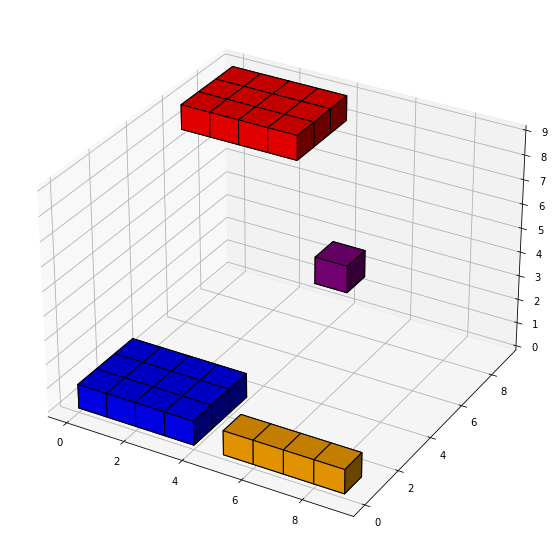

In [18]:
plot_compatible_shapes_simple(rectangle)

Not only can one surface or edge be compatible, but any of them will be compatible. In most dataframes, it is a matter of applying an operation either by the length or the width of the dataframe. This is relatively intuitive, becuase if you input an array that is not compatible with the other side, then, when it reaches the point when one array is longer than the other there will be nothing for it to do. 

these are all the compatible shapes that fit with this box. When it is visualized it can be easier to see than explaining it using words.


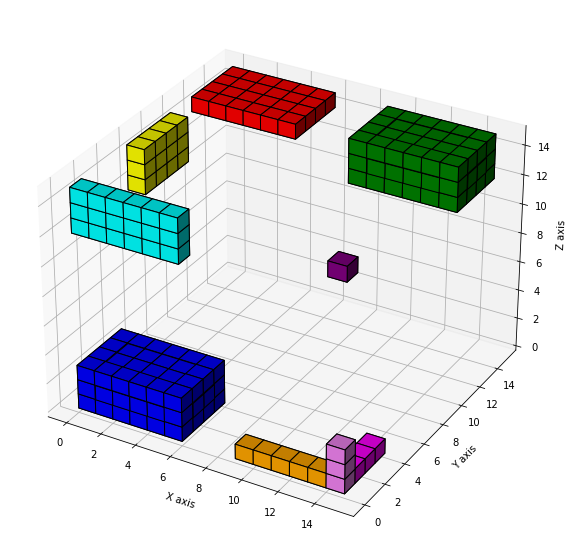

In [19]:
plot_all_compatible_shapes(long_box)

Since these shapes ar 

Now that we have some shapes, let's look at their properies when it comes to broadcasting compatiblity.

In [20]:

print(f'shape of one corner is: {corner.shape}')
print(f'the shape of an edge is {edge.shape}')
print(f'the shape of a surface is {square.shape}')
print(f'the shape of a cube is {cube.shape}')

shape of one corner is: ()
the shape of an edge is (3,)
the shape of a surface is (3, 3)
the shape of a cube is (3, 3, 3)


Now, although it appears that these shapes are compatible, they are missing a key detail. Part of the definition is that each dimension needs to be equal to eachother, or equal to one. 

This technicality is addressed by Pandas and isn't a big deal. However, each of these objects needs to be extended into a 3D space.

For example, if we draw a line with a pencil, it is for all intents and purposes a 1D line. However, if we get very specific, the mark from the pencil is 3D. although it is extremely flat it exists in 3D space, the graphite on top of the paper adds height on top of the paper. In everyday life, this fact is unimportant, but in math it is important and will throw an error if the objects are not the same dimension.

Let's extrude these out to the next dimension.

In this case, we can do it by nesting it inside of a python list


In [21]:
edge = np.reshape(edge,(edge.shape[0],1,1))
surface = np.reshape(surface,(surface.shape[0],surface.shape[1],1))


Another way to do this is to use nested python lists, and include empty brackets rather than use np.reshape

In [22]:
corner = np.array([[[1]]]) #0D Point
edge = np.array([[[1,1,1]]]) #1D Line
square = np.array([[1,1,1],[1,1,1],[1,1,1]])
surface = np.array([square]) # Extrudes square into 3D space 


#Not necessary to extrude the following shapes because they are already 3D

#cube = np.array([square,square,square])
#box = np.array([square,square,square,square,square])


In [23]:

print(f'shape of one corner is: {corner.shape}')
print(f'the shape of an edge is {edge.shape}')
print(f'the shape of a surface is {surface.shape}')
print(f'the shape of a cube is {cube.shape}')

shape of one corner is: (1, 1, 1)
the shape of an edge is (1, 1, 3)
the shape of a surface is (1, 3, 3)
the shape of a cube is (3, 3, 3)


Now, our objects have been extended (extruded) into 3D space, they now meet the compatibility requirments. 



Another way to think about broadcasting works like this.

If we look at the original shape in the bottom, then our options get displayed on this 3D graph.
As you can see, all the the shapes share common dimensions.

The 3D compatibile shape is identical, meaning that every element in it gets broadcasted to every element in the orignal shape.



For a compatible 2D shape, it has to share the same side as the 3D shape. 

## Part 1: Operations in Tabular Data
<hr style="border:2px solid gray"> </hr>

Now that we know how to access our data, with indexing, we can apply the same idea behind broadcasting to use what can be called vectorized operations.

Although the low level implimentation is less straightforward, what pandas does is abstract a lot of the details that efficiently index data and allow us to access it and "broadcast" code to operate on data which meets this condition. The example that we will be using is the .str method in pandas


The .str method of a Pandas Series is extremely useful. In one single line, it can do many things that would require writing a loop in pure python.

The principle here is in two steps:

Step 1: Index 

Pass pandas an index and tell it which data you are selecting

Step 2: Apply

Give instructions to apply to the indexed data points. 

### Example 1: Converting data types: text to numbers
<hr style="border:1px solid gray"> </hr>

Often, when one loads data into a pandas dataframe, it will read a number as text rather than a number. Sometimes, it is straightforward as applying the .astype() method.

In [122]:

startupDataPath = DATA_DIR/'StartUpInvestments/investments_VC.csv'

startups_df = pd.read_csv(startupDataPath,encoding = 'unicode_escape')

# This removes whitespace in the columns 
startups_df.columns = [col.strip() for col in list(startups_df.columns)]

In [123]:
# Let's cull down our dataset to the more complete entries

startups_df.dropna(inplace=True,axis=0) 

In [124]:
startups_df.sample(5)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
40688,/organization/stimwave-technologies,Stimwave Technologies,http://stimwave.com,|Hardware + Software|,Hardware + Software,"47,15,000",operating,USA,AZ,Phoenix,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44801,/organization/ubiquity-broadcasting-corporation,Ubiquity Broadcasting Corporation,http://www.ubiquitycorp.com,|News|,News,"84,28,250",operating,USA,CA,Anaheim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4522,/organization/baynote,Baynote,http://baynote.com,|Search|Web Design|Reviews and Recommendations...,Reviews and Recommendations,"3,24,95,730",operating,USA,CA,SF Bay Area,...,0.0,0.0,4000000.0,10750000.0,13000000.0,4745730.0,0.0,0.0,0.0,0.0
2761,/organization/appcelerator,Appcelerator,http://appcelerator.com,|Mobility|Open Source|Mobile|Enterprise Software|,Enterprise Software,"9,08,81,020",operating,USA,CA,SF Bay Area,...,0.0,0.0,4100000.0,9000000.0,46100000.0,22000000.0,0.0,0.0,0.0,0.0
24562,/organization/logfire,LogFire,http://logfire.com,|Software|,Software,"82,50,000",operating,USA,GA,Atlanta,...,0.0,0.0,8250000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cleansing text data with pandas

One of the key features of pandas is what you can do using strings. If you can understand how to utilize this, you can automate ton of office work, potentially saving hours each week from tedious and repetative tasks.


 It is very possible to automate many tasks if you can understand how to process text data in pandas. 
In this case, data will originally be inputted as text rather than numbers. 

as type method. But, occassionally the code will be a bit fussy about extra spaces and commas that make it easier for people to read

Problem: 


##### Removing text characters from a sample

In [125]:
# Let's try this first
#startups_df['funding_total_usd'] = startups_df['funding_total_usd'].astype(np.int64)

This line will run an error, and will give you the first value where your operation failed. 
Why did this fail and how does the following line fix it? 

In [126]:
startups_df['funding_total_usd'] = startups_df['funding_total_usd'].str.replace(',','')

##### Series.str.replace()

This can allow you to replace a character, or set of characters quite easily. 

Pandas handles text quite well, and is full of methods which can be found in the documentation or through an internet search. 


Here is a link to the documentation which will give you an overview:

https://pandas.pydata.org/pandas-docs/version/0.23.4/text.html

This link is to the documentation to all of the functionality for pandas strings. If you need to do something, then this will be a great friend. 

https://pandas.pydata.org/docs/reference/api/pandas.Series.str.html


Let's try running the code again. Now that we have this, it should work

In [127]:
#startups_df['funding_total_usd'] = startups_df['funding_total_usd'].astype(np.int64)


Yet, we get another error, with a useful message. It shows that there is whitespace in this element of the pandas series. Most notebooks that one will come across are gleaming with code that runs perfectly.

However, to get to that point, it is these error messages from the python interpreter which will lead the way. It is much easier to have the interpreter find these discrepancies than to check manually.


#### .str.strip()

We can use the .str.strip() method to easily remove it, using only one line of code.

This will remove the whitespace from the beginning and  the end of the code.

In [128]:
startups_df['funding_total_usd'] = startups_df['funding_total_usd'].str.strip()

In [137]:
startups_df['funding_total_usd'] = np.where(startups_df['funding_total_usd'] == '-',0,startups_df['funding_total_usd'])

In [138]:
startups_df['funding_total_usd'] = startups_df['funding_total_usd'].astype(np.int64)

Now it works. Luckily for us, there were no errors. 

When dealing with large amounts of data, it is not only impractical, but impossible to check each value. 
Instead, we can rely on the python interpreter to find these error.

Although error messages contain some esoteric wording, generally, data exploration proceeds with encountering errors like this.



### Example 2: Creating a calculated field: (interaction features / grouping )
<hr style="border:1px solid gray"> </hr>

Using the concept of broadcasting and indexing, we can create a new column based on an indexing of our dataframe. These are useful in tabular models because we can quickly impliment domain expertise by telling the model to look for what we already know. This 

In [49]:
startups_df.sample(5)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
33228,/organization/pplconnect-inc,PPLCONNECT,http://www.pplconnect.mobi,|Mobile|,Mobile,"10,00,000",operating,CAN,QC,Montreal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41126,/organization/suncore,Suncore,http://www.suncoresolar.com,|Clean Technology|,Clean Technology,"29,00,000",operating,USA,CA,Anaheim,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16759,/organization/generous-deals,Generous Deals,http://www.GenerousDeals.com,|Retail|Discounts|Craigslist Killers|E-Commerce|,E-Commerce,"6,50,000",closed,USA,IL,Chicago,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9731,/organization/contactually,Contactually,http://www.contactually.com,|Sales and Marketing|Productivity Software|Saa...,Email,"40,00,000",operating,USA,DC,"Washington, D.C.",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28686,/organization/nephros,Nephros,http://nephros.com,|Medical Devices|Hardware + Software|,Medical Devices,"12,51,000",operating,USA,NJ,Newark,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In Pandas, it is very straightforward to add  columns together. Since the columns are the same shape, they obey the broadcasting rules. 

In [58]:
startups_df['round_D+'] = startups_df['round_D'] + startups_df['round_E'] + startups_df['round_F'] + startups_df['round_G'] + startups_df['round_H']

## Part 2 Brodcasting in Image Data
<hr style="border:2px solid gray"> </hr>

In this section we are going to show how broadcasting is implimented using image data. This is done in a couple ways. It can be applied across an entire image or with only a section of the image.

This principle can be applied from something as simple as seperating a color channel, to applying filters and doing edge detection.

In [85]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_file_path = str(IMAGE_DIR/'week1/highway.jpg') #opencv can't accept Path lib so a string is needed instead
img = cv2.imread(image_file_path)

In [86]:
# If the shape is none, then your image did not load.
img.shape

(640, 960, 3)

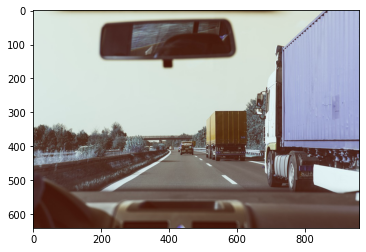

In [87]:
# Gaussian blur
img_array = np.array(img)
# weighs the middle more heavily 
plt.imshow(img_array)
plt.show()
# http://omz-software.com/pythonista/matplotlib/users/image_tutorial.html

Let's Take the shape, and see what we can do with it.


In [88]:
img_array.shape

(640, 960, 3)

### Seperating color channels

Here, let's try to broadcast a number to this array. Let's try this with the number zero.
What will happen to this image if we broadcast the number zero to it? 



In [89]:
zero_array = img_array * 0

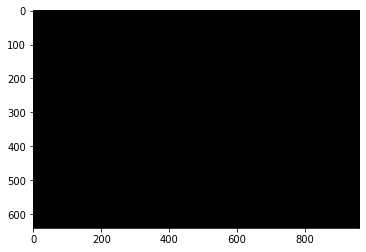

In [90]:
plt.imshow(zero_array)
plt.show()

It is not suprising that everything turned black. However, this is a bit crude. Let's increase the complexity of what we are doing and try to seperate out the color channels
What do you think will happen if we do this?


In [91]:
red_array = img_array * [1,0,0]

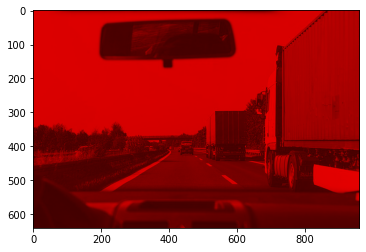

In [92]:
plt.imshow(red_array)
plt.show()

Can you seperate out the blue or green channel?

Bonus: Try to mess around with the values and see what happens, see if you can invent a new instagram filter

In [93]:
# See what instra

redValue = 0.5
greenValue = 0.4
blueValue = 0.8

fun_array = img_array * [redValue,greenValue,blueValue]
fun_array = np.array(fun_array.round(),dtype='uint8')
print(fun_array.max())

204


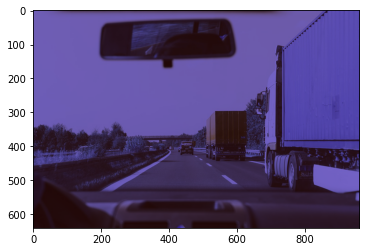

In [94]:
plt.imshow(fun_array)
plt.show()

In [95]:
vector = np.ones((img_array.shape[0]),dtype='uint8')
vector.shape

(640,)

If you want to expand 

In [98]:
list1 = []

for i in range(img_array.shape[0]):
    if i < (img_array.shape[0] / 2 ):
        list1.append(1)
    else:
        list1.append(0)
len(list1)

640

There's another problem that our list exists in 1D space. We need to expand it into 3D space. To meet the broadcasting rule, it needs to match a side, or the number one. 

* We need to change the list, so that it has the properties of width and height, even though they are only 1

In [99]:
vector = np.broadcast_to(list1,(1,1,640))

In [100]:
vector.shape

(1, 1, 640)

In [101]:
img_array.shape

(640, 960, 3)

The problem we have here is that the values do not match  exactly. These need to match down to the number, or it doesn't work 

The reason why is goes back to where the vector is. If the large value is in the x dimension, that means that it is pointing in that direction. If it is in the y dimension, it is pointing that way, and it is pointing here.

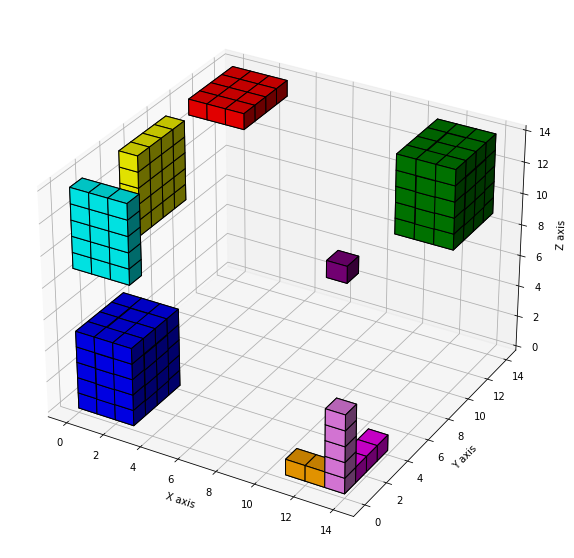

In [102]:
plot_all_compatible_shapes(example_image)

Let's transpose our matrix, and see what we can do.

In [103]:

vector = vector.T
vector.shape

(640, 1, 1)

In [104]:
new_array = img_array * vector

Now it works, let's plot it out.

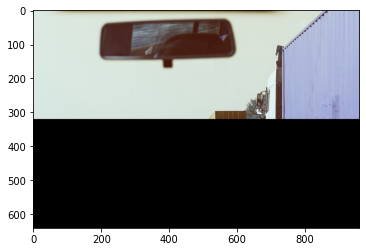

In [105]:
plt.imshow(new_array)
plt.show()

Why did it do this? 

#### Image Smoothing

Somthing that we take for granted with our eyes is the ability to process images automatically.

However, with pixels, not all is as meets the eyes. An image that may appear gray to us, might acually be a soup of black and white pixels that average out to us as grey. This can present a real problem when trying to identify different parts of an image. Since there is a wide range in the colors, it will affect the ability of the Computer Vision algoriths to pick up patterns inside of this noise. 

Luckily, we can apply this concept of broadcasting to the image in order to average out the pixel values to be more stable.

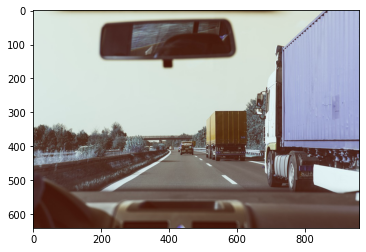

In [106]:
plt.imshow(img_array)

OpenCV is a tool in python that allows us to work with images in myriad ways. One of the first methods we can learn about are filters. We can apply a Gaussian blur filter to an image like this. 

In [107]:
gaussianBlurImg = cv2.GaussianBlur(img,(15,15),0)

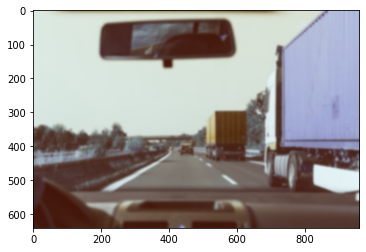

In [108]:
plt.imshow(gaussianBlurImg)

In [109]:
for i in range(10):
    gaussianBlurImg = cv2.GaussianBlur(gaussianBlurImg,(15,15),0)

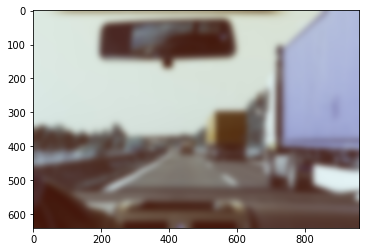

In [110]:
plt.imshow(gaussianBlurImg)

This is an extreme example of a Gaussian blur, because it destroys a lot of the detail in the image. But when applied lightly, it can help to even out the pixel values to eliminate noise. This is the most common filter that can be used.

OpenCV can save us a lot of time compared to implimenting the code ourselves, which we can try below if it interests you.

The following articles explain the concepts more in depth.

Higher level Concepts: https://www.pixelstech.net/article/1353768112-Gaussian-Blur-Algorithm


If you would like to see what happens under the hood by implimenting a filter by hand, this website is a good place to start.

Code Implimentation: http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/

In [111]:
#

### Edge Detection

Another extension of this same idea allows us to detect edges. In an image, the edges show up as sharp differences in pixel values. One color may show up differently than another. an edge detection kernel is designed to pick these up. 

It return a white pixel where there are differences in color, and a black pixel where the pixels around it are similar in color.

The first step in doing this is to conver the image to grayscale. This simplifies this process because we'll be dealing with a 2D matrix rather than a 3D Array. We aren't losing any information because it is looking for differences which will still be apparent in a grayscale. 

In [112]:
# Step 1: Convert to grayscale

grayscale_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

The following graph illustrates the differences in pixel values in different parts of the image. matplot lib is shown here because using different colors for shades of gray makes it makes the edges even more apparent to us. 

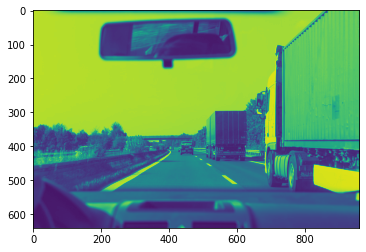

In [113]:
plt.imshow(grayscale_img)
plt.show()

In [114]:
edges = cv2.Canny(grayscale_img, threshold1=30, threshold2=100)


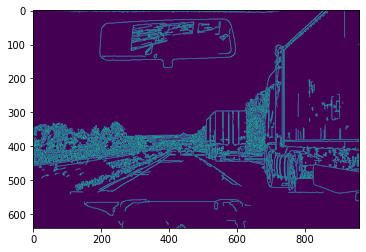

In [115]:
plt.imshow(edges)

In [116]:
###
blurredGrayscaleImage = cv2.GaussianBlur(grayscale_img,(11,11),0)

When we blur the image, it can cause the features to come out much more clearly because the noise in the trees and trucks are averaged  out in a way that eliminates the noise. 

In [117]:
edges = cv2.Canny(blurredGrayscaleImage, threshold1=30, threshold2=100)


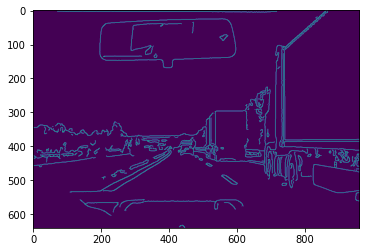

In [118]:
plt.imshow(edges)

# Discussion Questions

1. What is broadcasting? 

    *  A. Higher Dimensional math <br></br>

    *  B. Mathematical operations only between tensors of the same size <br></br>

    *  C. Mathematical operations between tensors that with a shape with dimensions (length,width, ect) which are identical, or are equal to 1. <br></br>

    *  D. Don't worry, Python takes care of the details <br></br>

2. Why is it faster to use vectorized operations than to iterate top to bottom, row by row?

    * A. It is more efficient, but doesn't offer the level of control and detail that for loops can offer. <br></br>

    * B. Numpy and Pandas use optimized C and Fortran Code which is always faster than Python. <br></br>

    * C. Since the order in which the operations are done isn't important, the array can be **processed at the same time** in a functional paradigm rather than **top down** in an imperative paradigm. <br></br>

    * D. Since the columns are quantifiable numbers, the Python interpreter doesn't have to slow down like it would for qualitative text data. <br></br>


3. What is the difference between tensor rank and shape? How do you get the rank from the shape? 

    * A. The shape refers to the number of dimensions in the tensor.
    <br></br>
    * B. The rank refers to the number of items in each dimension of the tensor.
    <br></br>
    * C. The shape refers to the number of items in each dimension of the tensor.
    <br></br>
    * D. The rank is equal to the number of numbers in the shape of the tensor.




# Discussion Exercises
<hr style="border:2px solid gray"> </hr>


The code example below illustrates the usage of numeric and conditional indexing of multi-dimensional arrays.

Example 1: Apply filters to the image using the openCV or PIL libraries.  This notebook provides an overview of different ways one can process images using opencv. Pick and choose what you find interesting or useful, and try to imagine how it is implemented.


https://www.kaggle.com/bulentsiyah/learn-opencv-by-examples-with-python/notebook

### Pandas Exercises

Create a new feature/dummy variable in the dataset through using a technique called "binning." This makes a column with only true/false values, while highlighting different parts of the dataset 

In [150]:
#Step 1, go through the dataset and find something
#that may interest you

startups_df['category_list'].sample(5)

2348                       |Public Relations|
39141                           |Health Care|
38961                      |Clean Technology|
3730     |Artists Globally|Audio|Music|Games|
11045                           |Advertising|
Name: category_list, dtype: object

In [149]:
#step 2, find out how many samples contain this phrase
startups_df['category_list'].str.contains('Entertainment').value_counts()

False    21524
True       316
Name: category_list, dtype: int64

In [ ]:
#Step 3 assign a new column to the dataframe
startups_df['is_entertainment'] = startups_df['category_list'].str.contains('Entertainment')

# Extension Ideas
<hr style="border:2px solid gray"> </hr>

Open up a dataset related to your area/areas of interest
and closely inspect what is in the dataset. See how you can apply these principles of vectorized operations. 